# Modelos Tradicionais (Baseline)

In [3]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import torch
from chronos import BaseChronosPipeline
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from datetime import timedelta
from pandas import IndexSlice as idx

###### Carregar e preparar o dataset

In [11]:
# Abrir o ficheiro
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

In [12]:
# Filtrar CP 2840 e ordenar
df_cp = df[df["ZipCode"] == "2840"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Colocar o item_id obrigatório para o AutoGluon
df_cp["item_id"] = "2840"
df_cp.set_index("DateTime", inplace=True)

###### Separar treino e teste (até 29-09) e teste (30-09)

In [13]:
treino = df_cp.loc[:'2023-09-29 23:00'].copy() # Treino até 29-09-2023 23:00
teste = df_cp.loc['2023-09-30 00:00':'2023-09-30 23:00'].copy() # Teste apenas para validação visual

treino_reset = treino.reset_index() # Reset index para usar com AutoGluon

###### Criar TimeSeriesDataFrame

In [16]:
train_data = TimeSeriesDataFrame.from_data_frame(
    treino_reset[["item_id", "DateTime", "EnergyNormalized"]],
    id_column="item_id",
    timestamp_column="DateTime"
)

# 📊ARIMA

###### importar modelo

In [ ]:
model_path = "AutogluonModels/ag-20250417_182601" # Caminho onde o modelo foi guardado

predictor = TimeSeriesPredictor.load(model_path) # Carregar o modelo

###### treinar

In [47]:
predictor = TimeSeriesPredictor(
    prediction_length=24,
    target="EnergyNormalized",
    eval_metric="MASE"
)

predictor.fit(
    train_data,
    presets="fast_training",
    hyperparameters={"ARIMA": {}},  # apenas ARIMA
    time_limit=300
)

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\AutogluonModels\ag-20250417_185656'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       4.20 GB / 15.93 GB (26.3%)
Disk Space Avail:   717.29 GB / 931.46 GB (77.0%)
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'ARIMA': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'EnergyNormalized',
 'time_limit': 300,
 'verbosity': 2}

Inferred time series frequency: 'h'

###### prever

In [48]:
forecast = predictor.predict(train_data)
forecast_values = forecast.loc["2840"]

# Lidar com possíveis múltiplas colunas
if isinstance(forecast_values, pd.DataFrame):
    y_pred = forecast_values.iloc[:, 0].values
else:
    y_pred = forecast_values.values

Model not specified in predict, will default to the model with the best validation score: ARIMA


###### Preparar dados reais

In [49]:
real_values = teste["EnergyNormalized"]
y_true = real_values.values

###### grafico

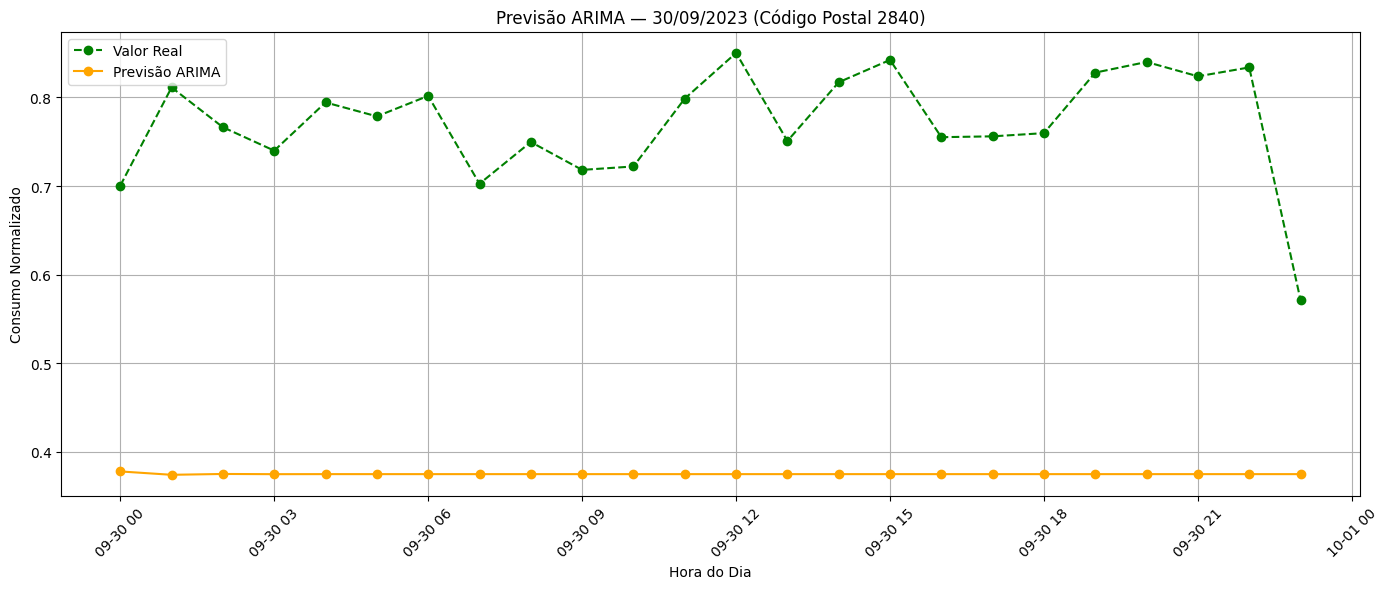

In [50]:
plt.figure(figsize=(14, 6))

plt.plot(real_values.index, real_values.values, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(forecast_values.index, forecast_values.iloc[:, 0] if isinstance(forecast_values, pd.DataFrame) else forecast_values,
         label="Previsão ARIMA", marker='o', color='orange')

plt.title("Previsão ARIMA — 30/09/2023 (Código Postal 2840)")
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("predicts/ARIMA/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

### 🧠 Interpretação geral
ARIMA não é suficiente para este tipo de série com: <br/>
    - Padrões horários<br/>
    - Picos de consumo previsíveis<br/>
    - Influência de variáveis exógenas (ex: temperatura, dia da semana)

In [51]:
# Métricas
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100

print(f"📊 MAE: {mae:.4f}")
print(f"📊 MSE: {mse:.4f}")
print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 MAPE: {mape:.2f}%")

📊 MAE: 0.3965
📊 MSE: 0.1609
📊 RMSE: 0.4012
📊 MAPE: 51.05%


### 📊 **Métricas de Avaliação**

| Métrica                                    | Valor  | Interpretação                                                                                                                                                                                                            |
|--------------------------------------------|--------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)              | 0.3965 | Em média, o erro absoluto foi de ~0.396 unidades normalizadas.                                                                                                 |
| **MSE** (Erro Quadrático Médio)            | 0.1609 | Erros maiores são penalizados; aqui está relativamente moderado.                                                                                                                      |
| **RMSE** (Raiz do Erro Quadrático Médio)   | 0.4012 | Raiz do MSE, dá uma ideia intuitiva da variação média do erro.                                                                                                                             |
| **MAPE** (Erro Percentual Absoluto Médio)  | 51.05% | O erro percentual médio é relativamente elevado (acima de 30% já é preocupante).                                                                                           |

# 📊XARIMA com variáveis exógenas

In [174]:
# Leitura e filtragem de dados
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')
df_cp = df[df["ZipCode"] == "2840"].sort_values("DateTime").copy()

# Renomeação e preparação do DataFrame
exogenous_features = [ 'Hour', 'DayOfTheWeek',  'IsWeekend',  'TimeOfDay', 'Season', 'Temperature', 'PopulationDensity']

df_cp['item_id'] = 'cp_2840' # Adicionar coluna item_id
df_cp = df_cp.rename(columns={'DateTime': 'timestamp', 'EnergyNormalized': 'target'})
df_cp['timestamp'] = pd.to_datetime(df_cp['timestamp']) # Garantir que a coluna timestamp está em datetime
# Criar o TimeSeriesDataFrame com variáveis exógenas
ts_df = TimeSeriesDataFrame(df_cp[['item_id', 'timestamp', 'target'] + exogenous_features])

In [175]:
# Dividir em treino e futuro
prediction_length = 24  # Previsão de 24h

# Obter índice das últimas 24 horas
train_data = ts_df[:-24]  # tudo menos as últimas 24 horas

last_timestamp = train_data.index.get_level_values("timestamp").max()

In [ ]:
# Treinar modelo com XARIMA (AutoGluon com variáveis exógenas)
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    freq="h",
    known_covariates_names=exogenous_features
).fit(train_data, presets="high_quality")

### 🧩 **Objetivo**
Treinar um modelo de previsão de consumo energético (para o código postal 2840), considerando:
- **Série temporal horária (frequência: `h`)**
- **Previsão para as próximas 24 horas**
- **Variáveis exógenas**: hora, dia da semana, fim de semana, período do dia, estação do ano, temperatura e densidade populacional.

---

### ⚙️ **Configuração do AutoGluon**
- **Preset**: `high_quality` (usa modelos avançados e mais tempo de treino)
- **Métrica de avaliação**: `WQL` (*Weighted Quantile Loss*) – mede a qualidade das previsões em diferentes níveis de quantis.
- **Modelos testados automaticamente**: 12 modelos (estatísticos, machine learning e deep learning).

---

### 🧠 **Modelos Treinados**
Entre os modelos destacados:
- 🔥 **DeepAR**: melhor desempenho individual (`WQL = -0.1820`)
- ✅ **Temporal Fusion Transformer**, **TiDE**, **PatchTST**: modelos deep learning modernos.
- 🧊 **AutoETS**, **DynamicOptimizedTheta**: modelos estatísticos clássicos.
- 🧪 **ChronosZeroShot[bolt_base]**: modelo pré-treinado da Amazon.
- ⚠️ **ChronosFineTuned[bolt_small]** falhou (problema técnico interno do AutoGluon).

---

### 🏆 **Modelo Escolhido: WeightedEnsemble**
AutoGluon criou automaticamente um **ensemble ponderado**, que combina os melhores modelos com os seguintes pesos:

| Modelo                       | Peso |
|-----------------------------|------|
| **DeepAR**                  | 0.85 |
| DynamicOptimizedTheta       | 0.13 |
| TiDE                        | 0.02 |

✅ Isto permite melhorar a precisão geral e reduzir o risco de overfitting.

---

### 📊 **Desempenho Final**
- **Score final (`WQL`) do ensemble**: `-0.1642` (quanto mais próximo de zero, melhor)
- Este score indica **boa qualidade de previsão com incerteza controlada**.
- O tempo total de treino foi de **~10 minutos (617s)**, o que é aceitável dado o preset `high_quality`.

---

### 📌 Conclusão
- **Treino concluído com sucesso**
- **Variáveis exógenas foram integradas corretamente**
- **Ensemble** melhorou o desempenho combinando modelos
- Pronto para prever e avaliar com métricas como MAE, MAPE, RMSE!





In [176]:
# importar (ou carregar) um modelo treinado com AutoGluon TimeSeries
model_path = "AutogluonModels/ag-20250417_102052"
predictor = TimeSeriesPredictor.load(model_path) # Importar o modelo

Loading predictor from path D:\githubProjects\previsao-do-consumo-energetico-com-ml\AutogluonModels\ag-20250417_102052


In [177]:
# 1. Obter o último timestamp do treino
# Prepara o intervalo desejado
forecast_start = last_timestamp + timedelta(hours=1)
forecast_end = forecast_start + timedelta(hours=predictor.prediction_length - 1)

# Filtra os dados dentro desse intervalo
future_data = ts_df.loc[
    (ts_df.index.get_level_values("timestamp") >= forecast_start) &
    (ts_df.index.get_level_values("timestamp") <= forecast_end)
]

# 2. Gerar os 24 timestamps seguintes
future_timestamps_full = pd.date_range(
    start="2023-09-30 00:00:00",
    periods=24,
    freq="h"
)

future_timestamps = future_timestamps_full[-predictor.prediction_length:] # Usa só os últimos 24 (os que o modelo precisa)

# 3. Construir o DataFrame com exogenous features futuras
future_covariates_df = pd.DataFrame({
    "item_id": ["cp_2840"] * len(future_timestamps),
    "timestamp": future_timestamps,
})
future_covariates_df["item_id"] = "cp_2840" # Garante que o mesmo item_id usado no treino é usado nas novas features
future_covariates_df["timestamp"] = pd.to_datetime(future_covariates_df["timestamp"], utc=False) # Garante que 'timestamp' é datetime
future_covariates_df["Hour"] = future_covariates_df["timestamp"].dt.hour
future_covariates_df["DayOfTheWeek"] = future_covariates_df["timestamp"].dt.dayofweek
future_covariates_df["IsWeekend"] = future_covariates_df["DayOfTheWeek"].isin([5, 6]).astype(int)
future_covariates_df["TimeOfDay"] = pd.cut(future_covariates_df["Hour"], bins=[-1,5,11,17,21,24], labels=["Madrugada_1", "Manhã", "Tarde", "Noite", "Madrugada_2"], ordered=False)
future_covariates_df["Season"] = future_covariates_df["timestamp"].dt.month.map({
    12: "Inverno", 1: "Inverno", 2: "Inverno",
    3: "Primavera", 4: "Primavera", 5: "Primavera",
    6: "Verão", 7: "Verão", 8: "Verão",
    9: "Outono", 10: "Outono", 11: "Outono"
}).astype(str)

# Remontar corretamente o MultiIndex com timestamp alinhado
future_covariates_df.set_index(["item_id", "timestamp"], inplace=True)
future_covariates_df.sort_index(inplace=True)

# Usa médias fixas para variáveis ambientais
future_covariates_df["Temperature"] = df_cp["Temperature"].mean()
future_covariates_df["PopulationDensity"] = df_cp["PopulationDensity"].mean()

# 4. Converter para TimeSeriesDataFrame
future_covariates_ts = TimeSeriesDataFrame(future_covariates_df)

forecast_start = train_data.index.get_level_values("timestamp").max() + timedelta(hours=1)

# Cortar apenas os timestamps de previsão
forecast_index = pd.MultiIndex.from_product(
    [["cp_2840"], future_timestamps],
    names=["item_id", "timestamp"]
)

# Cortar os dados
future_covariates_ts = future_covariates_ts.loc[forecast_index]

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


<Axes: title={'center': 'Previsão'}, xlabel='timestamp'>

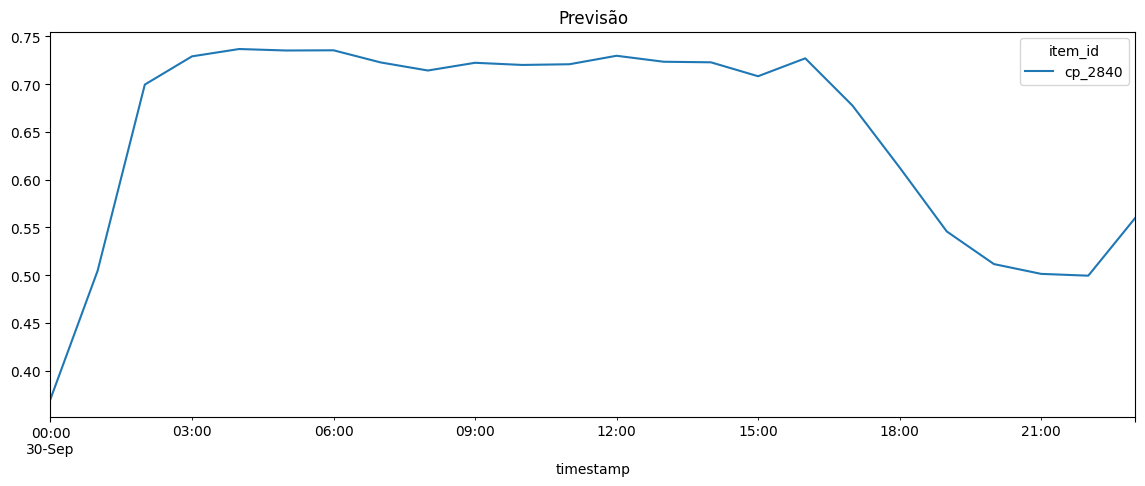

In [178]:
# Definir cutoff no fim de 29/09
cutoff = "2023-09-29 23:00:00"

# Timestamps do dia 30
future_timestamps_30 = pd.date_range("2023-09-30 00:00:00", periods=24, freq="h")

# Remover timezone se necessário
future_covariates_ts.index = future_covariates_ts.index.set_levels(
    future_covariates_ts.index.levels[1].tz_localize(None),
    level="timestamp"
)

# Filtrar covariáveis apenas para cp_2840 e 30/09
mask = (
    (future_covariates_ts.index.get_level_values("item_id") == "cp_2840") &
    (future_covariates_ts.index.get_level_values("timestamp").isin(future_timestamps_30))
)
future_covariates_ts_30 = future_covariates_ts.loc[mask]

# Previsão
forecast = predictor.predict(
    ts_df.loc[ts_df.index.get_level_values("timestamp") <= cutoff],
    known_covariates=future_covariates_ts_30
)

# Converter para DataFrame
forecast_df = forecast.reset_index()

# Plot
forecast_df.pivot(index="timestamp", columns="item_id", values="mean").plot(
    figsize=(14, 5),
    title="Previsão"
)

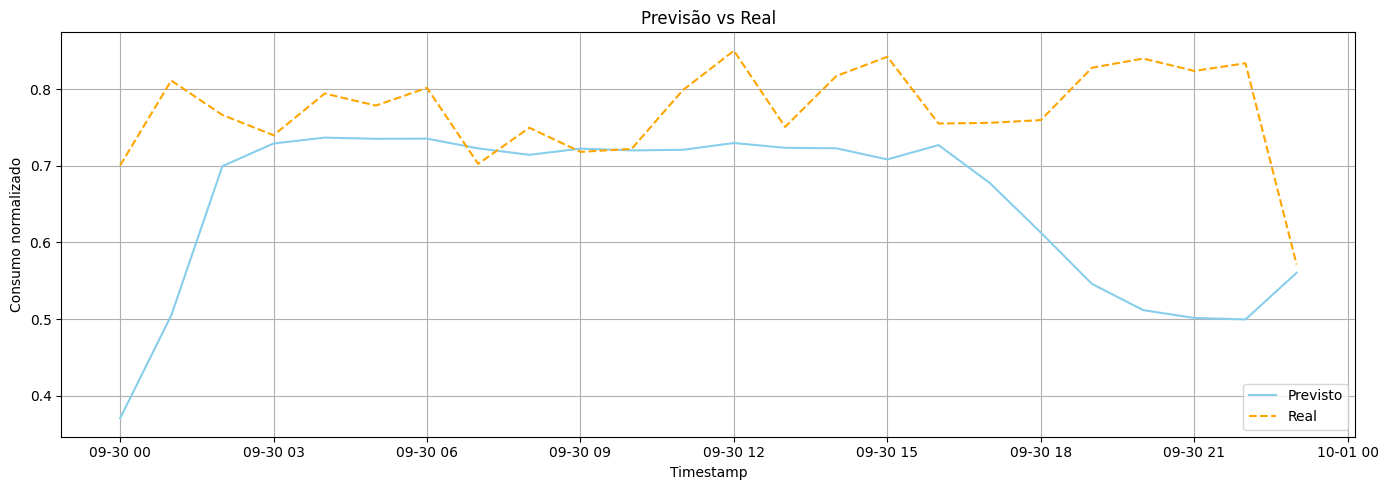

In [179]:
# Tira timezone da série de timestamps do forecast
forecast_timestamps = pd.to_datetime(forecast_df["timestamp"]).dt.tz_localize(None)

# Garante que o ts_df está sem timezone
ts_df = ts_df.copy()
ts_df.index = ts_df.index.set_levels(ts_df.index.levels[1].tz_localize(None), level="timestamp")

# Converter para strings YYYY-MM-DD HH:MM:SS para garantir precisão
forecast_str = forecast_timestamps.dt.strftime("%Y-%m-%d %H:%M:%S")
ts_df_str = ts_df.index.get_level_values("timestamp").strftime("%Y-%m-%d %H:%M:%S")

# Criar máscara booleana manual
mask = (
    (ts_df.index.get_level_values("item_id") == "cp_2840") &
    (ts_df_str.isin(forecast_str))
)

# Aplicar filtro
reais_df = ts_df.loc[mask][["target"]].reset_index()

# Garantir que os timestamps do forecast também estão sem timezone
forecast_df["timestamp"] = pd.to_datetime(forecast_df["timestamp"]).dt.tz_localize(None)

# Merge das previsões com os dados reais
comparacao_df = pd.merge(forecast_df, reais_df, on=["item_id", "timestamp"], how="left")

# Plot Previsão vs Real
plt.figure(figsize=(14, 5))
plt.plot(comparacao_df["timestamp"], comparacao_df["mean"], label="Previsto", color="skyblue")
plt.plot(comparacao_df["timestamp"], comparacao_df["target"], label="Real", color="orange", linestyle="--")
plt.title("Previsão vs Real")
plt.xlabel("Timestamp")
plt.ylabel("Consumo normalizado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('predicts/XARIMA/previsao-vs-real.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Guardar o modelo

In [180]:
# Avaliar
# Últimos 24 reais
y_true = df_cp["target"].values[-prediction_length:]
y_pred = forecast["mean"].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
margin_error = np.mean(np.abs(y_true - y_pred)) / np.mean(y_true) * 100

print(f"📊 MAE: {mae:.4f}")
print(f"📊 MSE: {mse:.4f}")
print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 MAPE: {mape:.2f}%")
print(f"📊 Margem de Erro Média: {margin_error:.2f}%")

📊 MAE: 0.1220
📊 MSE: 0.0291
📊 RMSE: 0.1706
📊 MAPE: 15.30%
📊 Margem de Erro Média: 15.82%
